In [1]:
!pip install diffusers transformers accelerate torch procgen xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Goal generation with Natural Language - Proof of Concept

Simple proof-of-concept of our approach with Stable Diffusion applied to the maze environment from procgen

## CUDA Utils

In [2]:
import torch
import gc

In [3]:
# set this to 'cpu' for CPU and 'cuda' for GPU
device = "cuda"

In [4]:
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True

In [5]:
def clear_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()  # https://forums.fast.ai/t/clearing-gpu-memory-pytorch/14637
    gc.collect()

## Procgen

In [6]:
from PIL import Image
from procgen import ProcgenGym3Env

In [7]:
maze_env = ProcgenGym3Env(
    num=1,
    env_name="maze",
    start_level=33,
    num_levels=1,
)

In [8]:
rew, obs, first = maze_env.observe()

Original dimensions W, H:  64 64
Scaling to 768x768


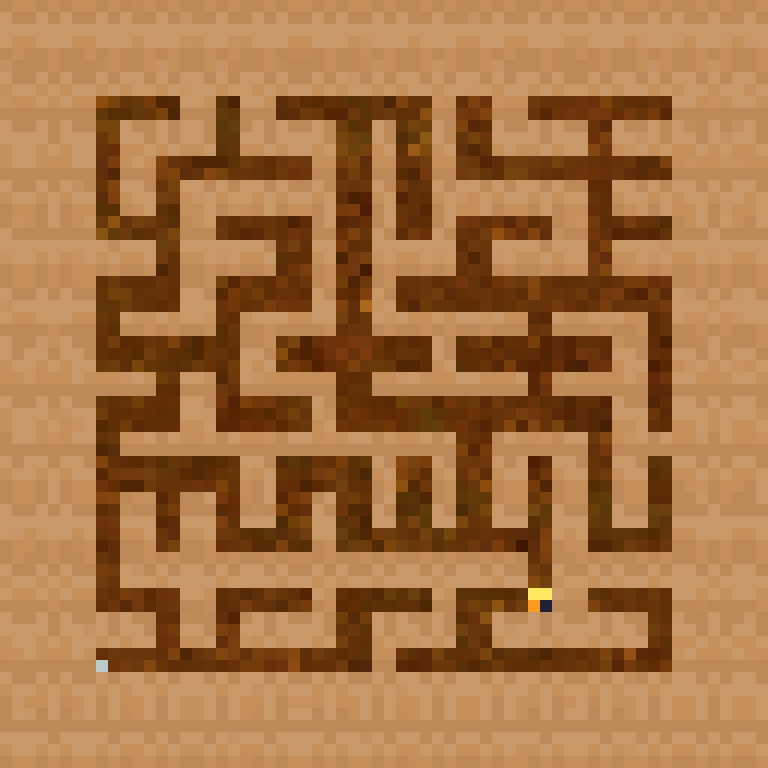

In [9]:
start_state_arr = obs["rgb"].squeeze()

width = start_state_arr.shape[1]
height = start_state_arr.shape[0]
print("Original dimensions W, H: ", width, height)
display_scaling = 8
print(f"Scaling to 768x768")
start_state_image = Image.fromarray(start_state_arr)
start_state_image.resize((768, 768), Image.NEAREST)

In [10]:
# make sure our conditioning image is at most 768 by 768 in size
start_state_image.thumbnail((786, 768), resample=Image.NEAREST)
large_start_state = start_state_image.resize((768, 768), Image.NEAREST)
large_start_state.thumbnail((768, 768), resample=Image.NEAREST)

## Diffusion

In [11]:
import diffusers

Error caught was: No module named 'triton'


In [12]:
diffusion_pipeline = diffusers.DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [13]:
diffusion_pipeline.to(device)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.14.0",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [14]:
# check if it works
output = diffusion_pipeline("An image of a squirrel in Picasso style")

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


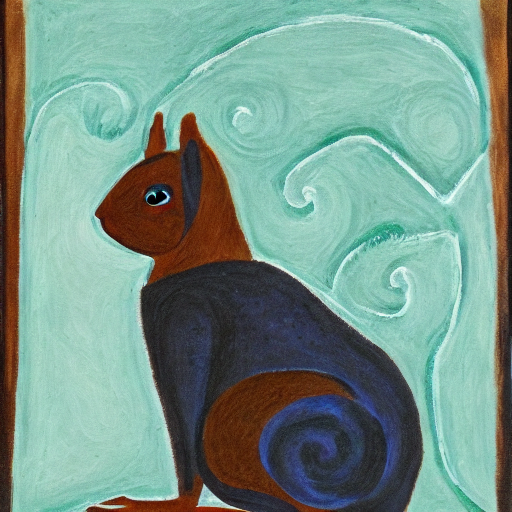

In [15]:
output_image = output.images[0]
print(type(output_image))
output_image

Seems like it does work!

In [16]:
# let's see if we can directly generate our goal state
output = diffusion_pipeline(
    "The OpenAI Procgen Maze environment, with the cheese succesfully collected"
)

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


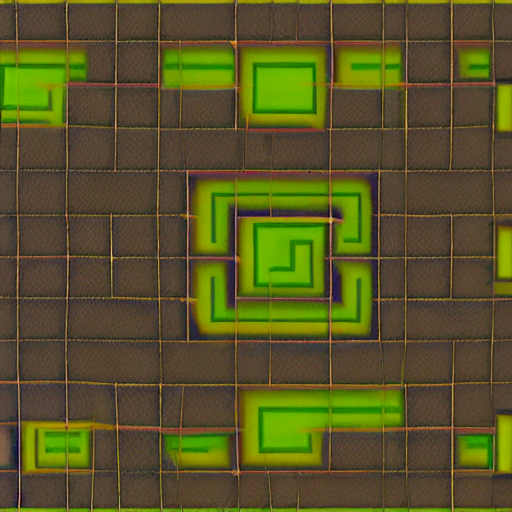

In [17]:
output_image = output.images[0]
print(type(output_image))
output_image

Ok, conditioning on text alone is probably going to be very difficult to generate our goal state. As expected, we need to condition on the start state too, and use text for guidance.

## Generating Procgen Goal States with image-condition text-guided diffusion

### Naive Text-Guided Img2Img

In [18]:
# our diffusion pipeline needs to change now:

img2img_tg = diffusers.StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
)
# memory optimizations
img2img_tg.enable_model_cpu_offload()
img2img_tg.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [19]:
# the text guidance
prompt = "The procgen maze environment, with all the cheese collected"

In [20]:
output = img2img_tg(
    prompt=prompt, image=large_start_state, strength=0.75, guidance_scale=7.5
)

  0%|          | 0/37 [00:00<?, ?it/s]

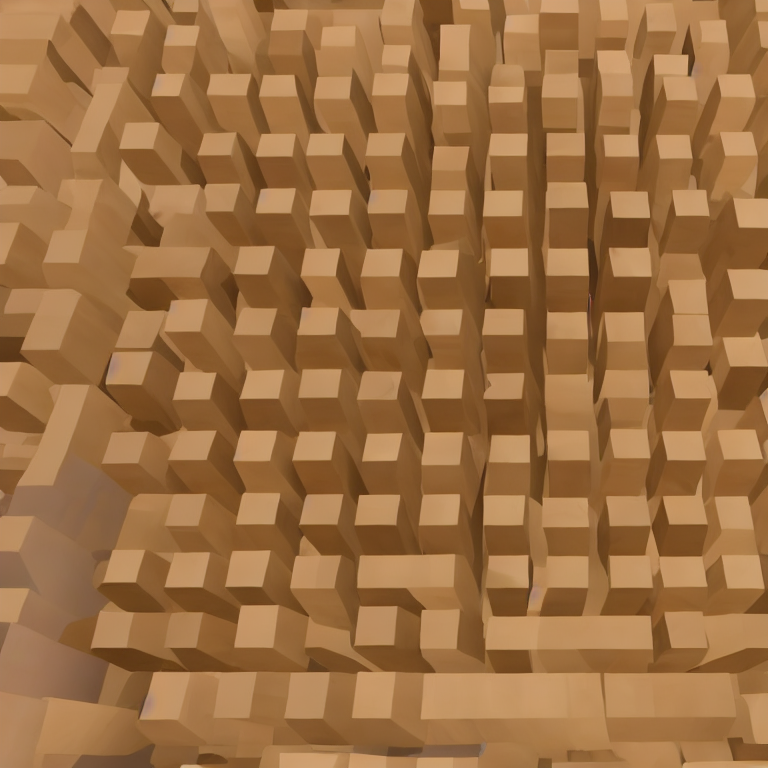

In [21]:
output.images[0]

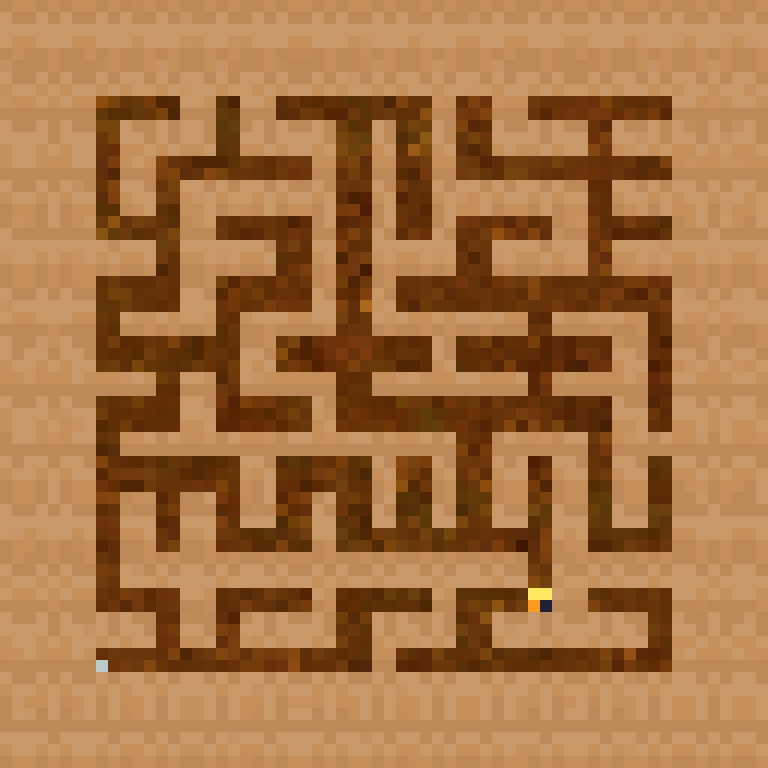

In [22]:
large_start_state

Uh-oh. Well that didn't work very well.

In [23]:
clear_cuda_memory()

Let's try with different pipelines. I don't think I will get very lucky with prompting alone, and it has too high variance.

### InstructPix2Pix


In [24]:
model_id = "timbrooks/instruct-pix2pix"
pipe = diffusers.StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id, safety_checker=None, torch_dtype=torch.float16
)
# memory optimizations
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

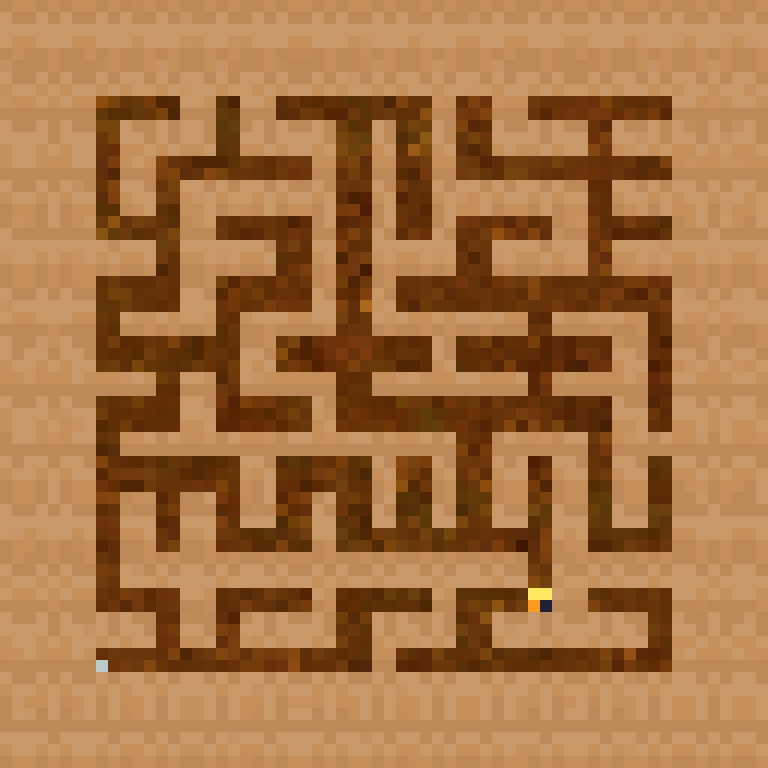

In [25]:
# note, I have tried several prompts
prompt = "Remove the cheese"
large_start_state

In [26]:
output = pipe(prompt, image=large_start_state)

  0%|          | 0/100 [00:00<?, ?it/s]

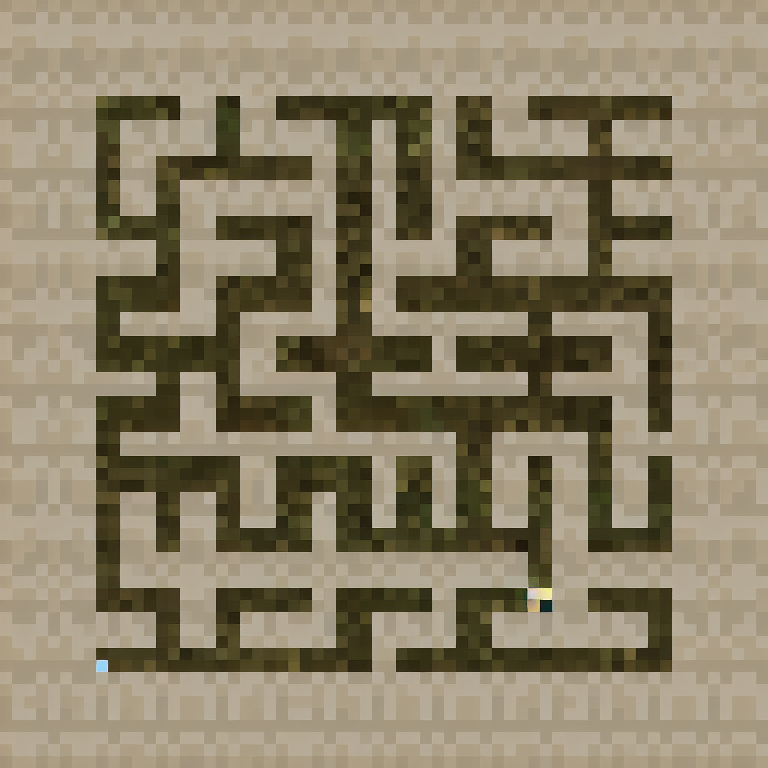

In [27]:
output.images[0]

In [28]:
clear_cuda_memory()

It doesn't seem to work very well! We may want to try more off-the-shelf models provided by the [diffusers library for controlled generation](https://huggingface.co/docs/diffusers/using-diffusers/controlling_generation) before moving on to more advanced approaches. 